In [2]:
# comparing the performance of different models on the same dataset

# imports
from transformers import pipeline
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianliu03/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [86]:
# get pre-trained model
# classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)
# classifier = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student", top_k=None)
# classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", top_k=None)
# classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english", top_k=None)

In [31]:
# stop words for filtering
stopwords = set(nltk.corpus.stopwords.words('english'))

In [32]:
# load different texts
text = open('text_stimuli/01_1.txt').read()[58:]
text_sentences = nltk.sent_tokenize(text.replace('\n', ' '))
text_words = nltk.word_tokenize(text)
text_stop_words = [w for w in text_words if w.lower() not in stopwords and w not in string.punctuation]
text_stop_sentences = [
    ' '.join([word for word in s.split() if word.lower() not in stopwords])
    for s in text_sentences
]

In [87]:
# get predictions
predictions_sentences = classifier(text_sentences)
predictions_words = classifier(text_words)
predictions_stop_words = classifier(text_stop_words)
predictions_stop_sentences = classifier(text_stop_sentences)

In [88]:
# get dataframes
df_sentences = pd.DataFrame(predictions_sentences).stack().apply(pd.Series).reset_index(names=['sentence', 'emotion'])
# reshape dataframe
df_sentences = df_sentences.pivot_table(columns='label', index='sentence', values='score')

df_words = pd.DataFrame(predictions_words).stack().apply(pd.Series).reset_index(names=['word', 'emotion'])
df_words = df_words.pivot_table(columns='label', index='word', values='score')

df_stop_words = pd.DataFrame(predictions_stop_words).stack().apply(pd.Series).reset_index(names=['word', 'emotion'])
df_stop_words = df_stop_words.pivot_table(columns='label', index='word', values='score')

df_stop_sentences = pd.DataFrame(predictions_stop_sentences).stack().apply(pd.Series).reset_index(names=['sentence', 'emotion'])
df_stop_sentences = df_stop_sentences.pivot_table(columns='label', index='sentence', values='score')

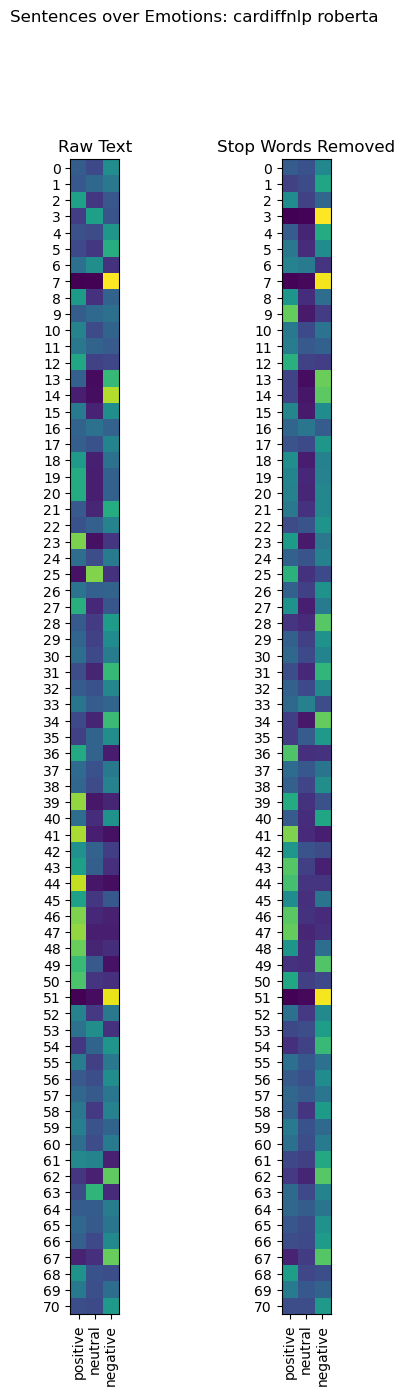

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,15))
fig.suptitle('Sentences over Emotions: cardiffnlp roberta')

column_order = ['positive', 'neutral', 'negative']
# plot df_sentences
ax1.imshow(df_sentences, cmap='viridis')
ax1.set_title('Raw Text')
ax1.set_yticks(np.arange(len(df_sentences.index)))
ax1.set_yticklabels(df_sentences.index)
ax1.set_xticks(np.arange(len(df_sentences.columns)))
ax1.set_xticklabels(column_order, rotation=90)

# plot df_stop_sentences
ax2.imshow(df_stop_sentences, cmap='viridis')
ax2.set_title('Stop Words Removed')
ax2.set_yticks(np.arange(len(df_stop_sentences.index)))
ax2.set_yticklabels(df_stop_sentences.index)
ax2.set_xticks(np.arange(len(df_stop_sentences.columns)))
ax2.set_xticklabels(column_order, rotation=90)

plt.show()

In [90]:
# get cumulative means for df
df_sentences_cs = df_sentences.expanding().mean()
df_words_cs = df_words.expanding().mean()
df_stop_words_cs = df_stop_words.expanding().mean()
df_stop_sentences_cs = df_stop_sentences.expanding().mean()

In [74]:
# remove insignificant emotions
df_sentences_cs = df_sentences_cs.drop(columns=df_sentences_cs.iloc[-1].nsmallest(18).index)
df_stop_sentences_cs = df_stop_sentences_cs.drop(columns=df_stop_sentences_cs.iloc[-1].nsmallest(18).index)

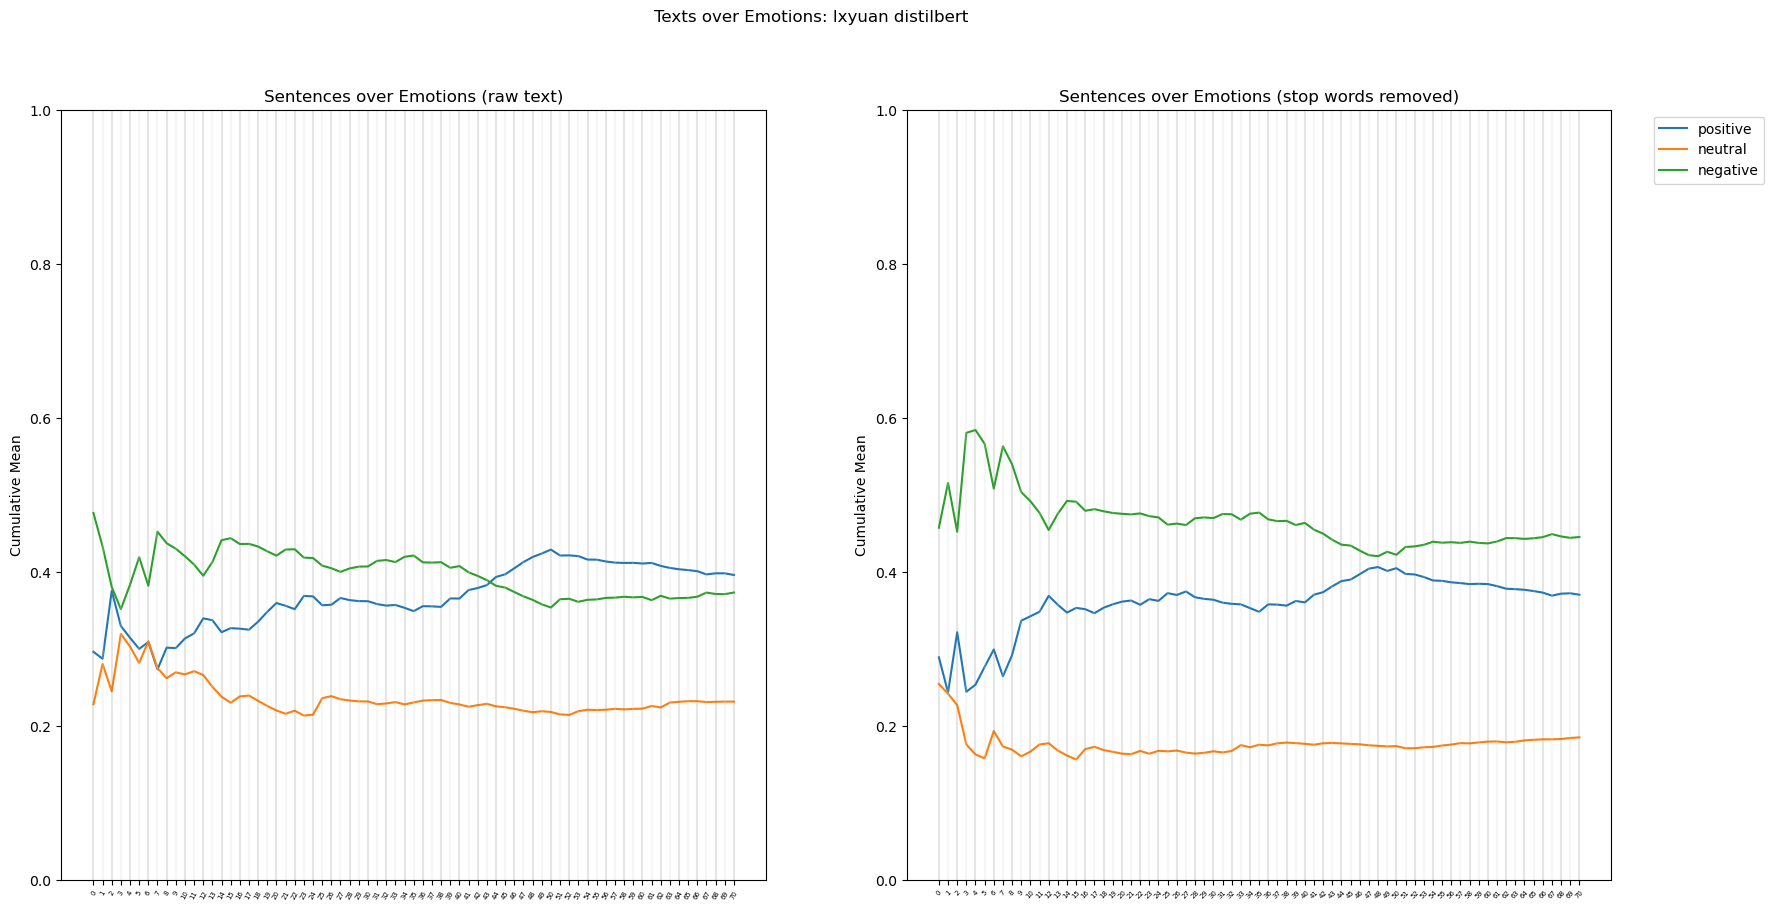

In [92]:
# plot as line graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Texts over Emotions: lxyuan distilbert')

# plot df_sentences_cs
ax1.plot(df_sentences_cs)
ax1.set_title('Sentences over Emotions (raw text)')
ax1.set_xticks(np.arange(len(df_sentences_cs.index)))
ax1.set_xticklabels(df_sentences_cs.index, rotation=60, fontsize=5)
for i in range(len(df_sentences_cs.index)):
    if i % 2 == 0:
        ax1.axvline(i, color='grey', alpha=0.2)
    else:
        ax1.axvline(i, color='lightgrey', alpha=0.2)
ax1.set_ylabel('Cumulative Mean')
ax1.set_ylim([0, 1])

# plot df_stop_sentences_cs
ax2.plot(df_stop_sentences_cs)
ax2.set_title('Sentences over Emotions (stop words removed)')
ax2.set_xticks(np.arange(len(df_stop_sentences_cs.index)))
ax2.set_xticklabels(df_stop_sentences_cs.index, rotation=45, fontsize=5)
for i in range(len(df_stop_sentences_cs.index)):
    if i % 2 == 0:
        ax2.axvline(i, color='grey', alpha=0.2)
    else:
        ax2.axvline(i, color='lightgrey', alpha=0.2)
ax2.set_ylabel('Cumulative Mean')
ax2.set_ylim([0, 1])

legend_order = ['positive', 'neutral', 'negative']
# show legend
ax2.legend(legend_order, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()